In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [126]:
# Read in scores and convert to activity scores
"""
my_store = pd.HDFStore('2017.07.24_Radicicol_exp.h5')
myStoreKeys = my_store.keys()

pointMuts = my_store.select('/main/synonymous/scores')[2:]    # Dropped _sy and _wt (what is _sy?)
idx = [',' not in name for name in pointMuts.index.tolist()] 
pointMuts = pointMuts[idx]
pointMuts = pointMuts[pointMuts['Radicicol', 'score'].notna() & pointMuts['Zero', 'score'].notna()]
pointMuts['Radicicol_score'] = pointMuts['Radicicol', 'score']
pointMuts['Zero_score'] = pointMuts['Zero', 'score']
pointMuts = pointMuts.drop(columns = ['Radicicol', 'Zero'])
pointMuts.columns = [col[0] for col in pointMuts.columns]
pointMuts *= -1
pointMuts.to_csv('pointMuts_scores.csv')
"""
pointMuts = pd.read_csv('pointMuts_scores.csv', index_col = 0)

In [127]:
# Calculating ratios and residuals from activity scores instead of real scores

"""ratios = pointMuts['Radicicol_score'] / pointMuts['Zero_score']

sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
zerPointMutsHat = (b + m * pointMuts['Radicicol_score'])
plt.plot(pointMuts['Radicicol_score'], zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.legend()
plt.show()

resids = pointMuts['Zero_score'] - zerPointMutsHat
sns.distplot(resids, label = 'Residuals')
plt.xlabel('Rediduals')
plt.ylabel('Frequency')
plt.title('Residuals of OLS')
plt.show()

resids.to_csv('resids.csv')
ratios.to_csv('ratios.csv')"""

resids = pd.Series.from_csv('resids.csv')
ratios = pd.Series.from_csv('ratios.csv')

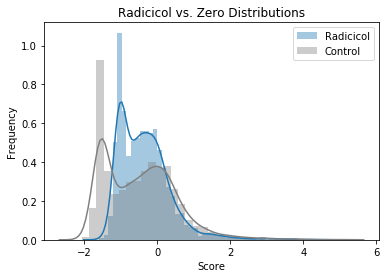

In [128]:
sns.distplot(pointMuts['Radicicol_score'], label='Radicicol')
sns.distplot(pointMuts['Zero_score'], label='Control', color='grey')
plt.legend()
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Radicicol vs. Zero Distributions')
plt.show()

In [129]:
# Constructing lists of 3 letter and 1 letter AA codes to build dictionary and DataFrame
AA3idx = [
    'Ala',
    'Val',
    'Leu',
    'Ile',
    'Met',
    'Phe',
    'Tyr',
    'Trp',
    'Ser',
    'Thr',
    'Asn',
    'Gln',
    'Cys',
    'Asp',
    'Glu',
    'His',
    'Lys',
    'Arg',
    'Gly',
    'Pro',
    'Ter'
]

AA1idx = [
    'A',
    'V',
    'L',
    'I',
    'M',
    'F',
    'Y',
    'W',
    'S',
    'T',
    'N',
    'Q',
    'C',
    'D',
    'E',
    'H',
    'K',
    'R',
    'G',
    'P',
    '*'
]

AAdict = dict(zip(AA3idx, AA1idx))

# Constructing heat maps with ratio and residual values
def makeHeatMap(df):
    muts = df.index.tolist()
    heatMapDF = pd.DataFrame(index = AA1idx, columns = np.arange(270, 520))   # the residue numbers are hard coded here
    for mut in muts:
        heatMapDF.loc[AAdict[mut[8:11]], int(mut[5:8])] = df[mut]
    return(heatMapDF)

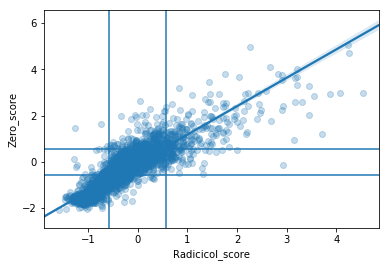

In [130]:
# Plotting GOF, LOF, and WT muts on bivariate plot 

sdRad = 0.2926579180309401
sdZero = 0.28323869489237435

sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
plt.axvline(-1.96 * sdRad)
plt.axvline(1.96 * sdRad)
plt.axhline(-1.96 * sdZero)
plt.axhline(1.96 * sdZero)
plt.show()

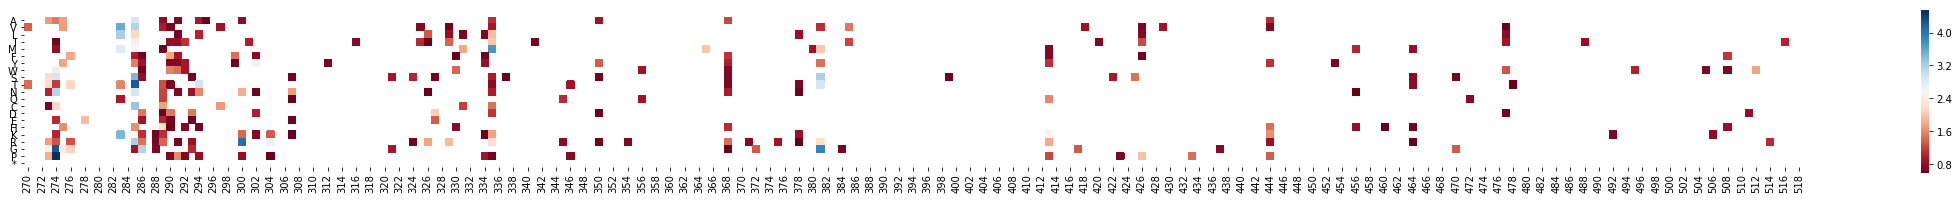

In [131]:
radGOF = pointMuts[pointMuts['Radicicol_score'] > (1.96 * sdRad)]['Radicicol_score']
radGOFMap = makeHeatMap(radGOF)
plt.figure(figsize = (40, 10))
sns.heatmap(radGOFMap.astype(float), mask = radGOFMap.isnull(), square = True, cbar_kws = {"shrink": 0.3}, cmap = "RdBu")
plt.show()

In [132]:
GOFmap = np.zeros(250)
for resid in [int(name[5:8]) for name in radGOF.index.tolist()]:
    GOFmap[resid - 270] += 1

In [133]:
# np.savetxt('./PyMOL/GOFmap.txt',GOFmap)

# 20190127: Finish making heatmaps

Radicicol_score
g


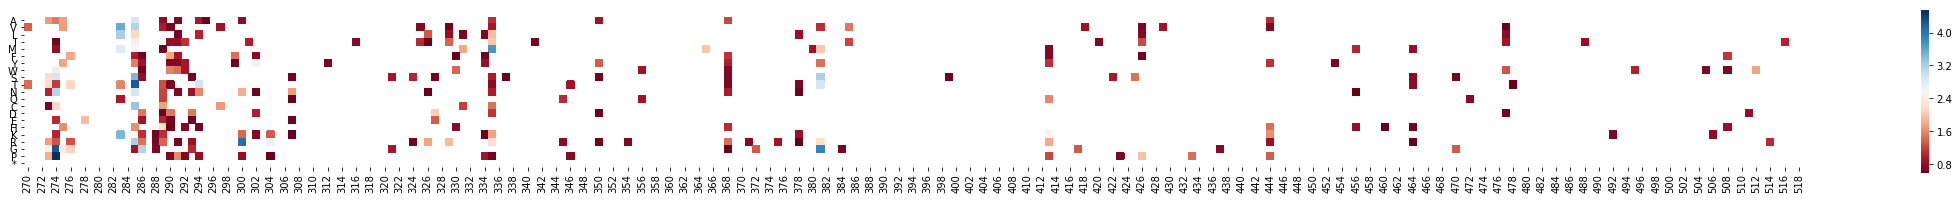

Enter filename: 


IOError: [Errno 21] Is a directory: './PyMOL/'

In [134]:
for condition, stdev in zip(['Radicicol_score', 'Zero_score'], [sdRad, sdZero]):
    for fxnType in ['g', 'l']:
        print(condition)
        print(fxnType)
        if fxnType is 'g':
            fxnDF = pointMuts[pointMuts[condition] > (1.96 * stdev)][condition]
        else:
            fxnDF = pointMuts[pointMuts[condition] < (-1.96 * stdev)][condition]
        plt.figure(figsize = (40,10))
        fxnMap = makeHeatMap(fxnDF)
        sns.heatmap(fxnMap.astype(float), mask = fxnMap.isnull(), square = True, cbar_kws = {"shrink": 0.3}, cmap = "RdBu")
        plt.show()
        

        txtMap = np.zeros(250)
        for resid in [int(name[5:8]) for name in fxnDF.index.tolist()]:
            txtMap[resid - 270] += 1
        filePath = './PyMOL/' + raw_input("Enter filename: ")
        np.savetxt(filePath, txtMap)

# 20190129: Hierarchical Clustering of Residuals

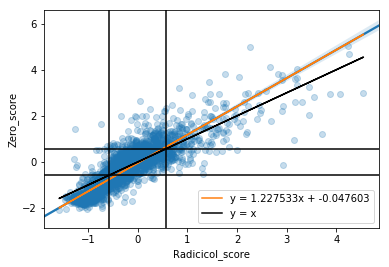

In [135]:
# Should we use line of best fit or line y = x?
[m, b] = np.polyfit(pointMuts['Radicicol_score'], pointMuts['Zero_score'], 1)
zerPointMutsHat = (b + m * pointMuts['Radicicol_score'])
sns.regplot(pointMuts['Radicicol_score'], pointMuts['Zero_score'], scatter_kws = {'alpha':0.25})
plt.plot(pointMuts['Radicicol_score'], zerPointMutsHat, label = 'y = %fx + %f' %(m, b))
plt.plot(pointMuts['Radicicol_score'],pointMuts['Radicicol_score'], color='k', label = 'y = x')
plt.axvline(-1.96 * sdRad, color = 'k')
plt.axvline(1.96 * sdRad, color = 'k')
plt.axhline(-1.96 * sdZero, color = 'k')
plt.axhline(1.96 * sdZero, color = 'k')
plt.legend()
plt.show()

In [187]:
# Making a PyMOL map for y = x residuals
yxResids = pointMuts['Zero_score'] - pointMuts['Radicicol_score']
sdyx = np.std(yxResids)
meanyx = np.mean(yxResids)
yxL = yxResids[yxResids < (meanyx - 1.96 * sdyx)]
yxH = yxResids[yxResids > (meanyx + 1.96 * sdyx)]
yxout = yxL + yxH
txtMap = np.zeros(250)
for resid in [int(name[5:8]) for name in yxout.index.tolist()]:
    txtMap[resid - 270] += 1
np.savetxt('./PyMOL/yxout.txt', txtMap)